In [1]:
import pymongo
import json
from bson import BSON
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import random
import tokenizer
import numpy as np
from multiprocessing import Pool
%matplotlib inline
import copy

In [2]:
tokenizer_object = tokenizer.Spacy_Tokenizer()

In [3]:
DATA_PATH = './ALL_DATA_2/'

FRESH_EXP = False

In [4]:
all_data_file_names = os.listdir(DATA_PATH)

In [5]:
all_words = pd.read_csv("./results/noFilter/allWords.csv")

In [6]:
all_words

,words,occurrences,frequency
0,être,255977,3.410142
1,avoir,212874,2.835921
2,et,208209,2.773773
3,que,136050,1.812467
4,il,113436,1.511202
...,...,...,...
106011,kammerer,1,0.000013
106012,aplasique,1,0.000013
106013,leucocyte,1,0.000013
106014,dv,1,0.000013


In [7]:
all_words['cumulative'] = all_words['frequency'].cumsum()

In [8]:
all_words

,words,occurrences,frequency,cumulative
0,être,255977,3.410142,3.410142
1,avoir,212874,2.835921,6.246062
2,et,208209,2.773773,9.019836
3,que,136050,1.812467,10.832303
4,il,113436,1.511202,12.343504
...,...,...,...,...
106011,kammerer,1,0.000013,99.999947
106012,aplasique,1,0.000013,99.999960
106013,leucocyte,1,0.000013,99.999973
106014,dv,1,0.000013,99.999987


In [9]:
important_words_80 = all_words[all_words['cumulative'] <= 80]['words']

In [10]:
important_words_80

0                être
1               avoir
2                  et
3                 que
4                  il
            ...      
2565          magasin
2566    démographique
2567          barnier
2568             peau
2569           saison
Name: words, Length: 2570, dtype: object

In [11]:
def perform_one_simulation(trial_index:int=0):
    print(f'Trial {trial_index} just started')
    important_words_80_freq = {}
    recently_visited_word_80_freq = {}
    for word in important_words_80:
        important_words_80_freq[word] = 0
        recently_visited_word_80_freq[word] = False


    max_of_epochcs = 50
    objective_reached = False
#     record_numbers = {"nb of articles": [], "objective": []}
    record_numbers = {}
    nb_of_repetition_to_success = 10
    nb_of_articles_per_epoch = 100

    article_cnt = 1

    while (max_of_epochcs > 0) and (objective_reached==False):
        sample_article_filenames = random.choices(all_data_file_names, k=nb_of_articles_per_epoch)
        for single_article_filename in sample_article_filenames:
            with open(DATA_PATH + single_article_filename, 'r') as file_handle:
                article_content = json.load(file_handle)
                all_words, verbs, nouns, adverbs, entities = tokenizer_object(article_content)
    #             print(all_words)

                # Add to the observations
                for word in all_words:
                    try:
                        important_words_80_freq[word] += all_words[word]
                        recently_visited_word_80_freq[word] = True
                    except:
                        continue
        # Account for forgetting - each non-visited word will get a -1
        for word in recently_visited_word_80_freq: 
            if recently_visited_word_80_freq[word] == False: # Apply the memory forgetting
                important_words_80_freq[word] -= 1
                if important_words_80_freq[word] < 0:
                    important_words_80_freq[word] = 0

            elif recently_visited_word_80_freq[word] == True: # Toggle it
                recently_visited_word_80_freq[word] = False
        
        # Calculate the current rewards - cap each word at at
        observed_words = 0
        for word in important_words_80_freq:
            if important_words_80_freq[word] > nb_of_repetition_to_success:
                observed_words += nb_of_repetition_to_success
            else:
                observed_words += important_words_80_freq[word]
            
        # Observed numbers so far
#         observed_words = np.sum(list(important_words_80_freq.values()))
        success_criteria = observed_words / (len(important_words_80_freq.keys()) * nb_of_repetition_to_success)
        if success_criteria >= 1:
            objective_reached = True
            print("Mission Accomplished!")

        max_of_epochcs -= 1
#         print(f'Epoch # : {max_of_epochcs} - Objective Tracking: {observed_words} - Progress Bar: {success_criteria}')

        # Record Progress for later
#         record_numbers['nb of articles'].append([article_cnt * nb_of_articles_per_epoch])
#         record_numbers['objective'].append(success_criteria)
        record_numbers[article_cnt] = success_criteria

        article_cnt += 1
    
    print(f'Trial {trial_index} ENDED -------------')
    
        
    return record_numbers

record_numbers = None
record_numbers_df = None
if FRESH_EXP:
    trial_indices = list(range(20))
    with Pool(4) as p:
        record_numbers = p.map(perform_one_simulation, trial_indices)
else:
    record_numbers_df = pd.read_json("simulation_results.json")

In [12]:
if FRESH_EXP:
    record_numbers_df = pd.DataFrame.from_records(record_numbers)
    record_numbers_df.to_json("simulation_results.json")
record_numbers_df

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,0.567782,0.759805,0.838444,0.881440,0.905875,0.921595,0.936342,0.942257,0.948638,0.953813,...,0.976848,0.977821,0.977043,0.977665,0.977899,0.978444,0.977588,0.978288,0.977665,0.977626
1,0.505058,0.716109,0.821673,0.878716,0.906381,0.919689,0.932101,0.939261,0.946265,0.951984,...,0.977860,0.978210,0.978482,0.979961,0.979611,0.979066,0.978599,0.978171,0.978249,0.978405
2,0.490117,0.683463,0.783696,0.844553,0.881051,0.904747,0.920428,0.933035,0.942140,0.948249,...,0.979027,0.979377,0.979455,0.980117,0.980428,0.980739,0.980700,0.980000,0.981128,0.980934
3,0.540973,0.731323,0.824280,0.869805,0.897082,0.917160,0.932296,0.942607,0.948833,0.953424,...,0.974047,0.974397,0.974202,0.974008,0.973580,0.973696,0.972996,0.974008,0.973930,0.973735
4,0.528327,0.708327,0.811984,0.871556,0.905486,0.924086,0.935058,0.942218,0.948210,0.953930,...,0.973113,0.974163,0.974825,0.975058,0.974125,0.974397,0.974669,0.975097,0.975759,0.976654
5,0.519222,0.708249,0.801712,0.855097,0.895798,0.913307,0.926537,0.936770,0.942529,0.948794,...,0.975019,0.976031,0.975837,0.976070,0.976732,0.976498,0.976304,0.976031,0.976537,0.976148
6,0.532646,0.711907,0.810778,0.861284,0.892840,0.909650,0.920973,0.933385,0.938599,0.943658,...,0.978210,0.977977,0.978132,0.978560,0.979377,0.978638,0.978288,0.978482,0.979572,0.978988
7,0.495409,0.702918,0.818482,0.877938,0.910039,0.925837,0.937160,0.940934,0.947471,0.951206,...,0.975798,0.975370,0.975292,0.975875,0.975953,0.977432,0.977160,0.977004,0.976654,0.976693
8,0.512763,0.716770,0.829689,0.882879,0.909844,0.927626,0.936926,0.946148,0.951751,0.958249,...,0.978327,0.978093,0.979027,0.978366,0.978405,0.978366,0.978016,0.979027,0.978755,0.979377
9,0.515370,0.717665,0.813813,0.871907,0.904708,0.923774,0.937237,0.947082,0.952257,0.954008,...,0.977160,0.976848,0.977121,0.977510,0.978249,0.978288,0.980545,0.980545,0.980428,0.981245


In [13]:
means = record_numbers_df.mean(axis=0)
stds = record_numbers_df.std(axis=0)
stats_of_experiment = pd.DataFrame({'mean': means, "std": stds}).transpose()
stats_of_experiment

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
mean,0.511397,0.710626,0.813891,0.869033,0.899747,0.919058,0.931331,0.939625,0.946438,0.951409,...,0.976588,0.976613,0.976722,0.976899,0.976998,0.977072,0.977089,0.977304,0.977350,0.977588
std,0.023497,0.018538,0.011981,0.009523,0.007791,0.006037,0.005354,0.004448,0.003932,0.003605,...,0.001816,0.001589,0.001562,0.001877,0.002080,0.001945,0.002198,0.001976,0.001965,0.001993


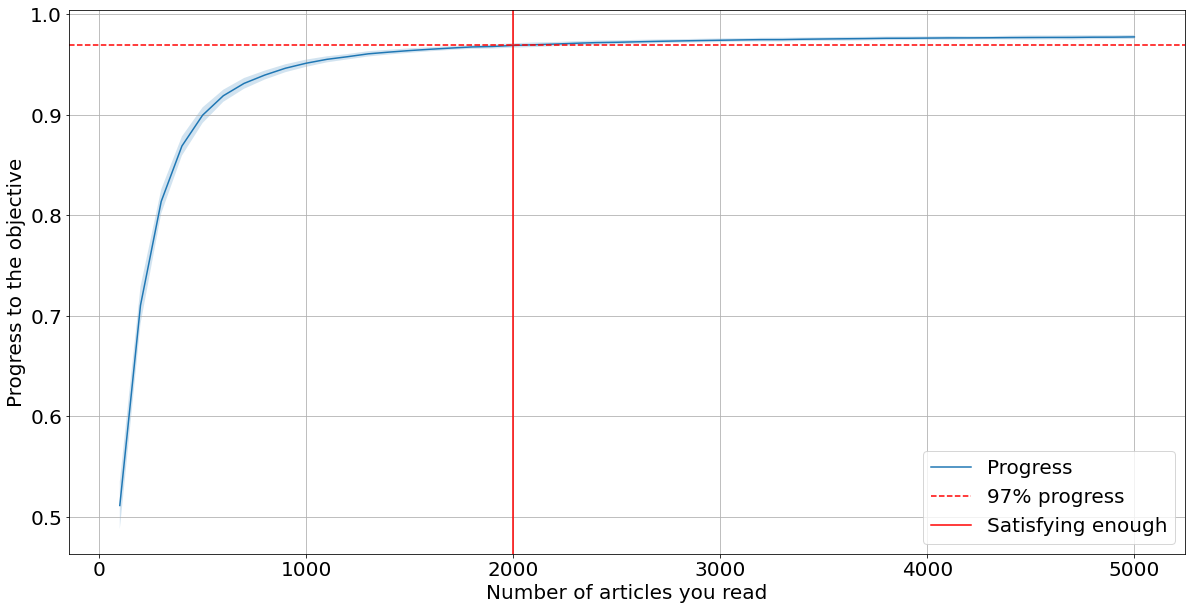

In [14]:
plt.rc('font', size=20) #controls default text size
plt.figure(figsize=(20, 10))
plt.plot(stats_of_experiment.columns * 100, stats_of_experiment.loc['mean'], label='Progress')
plt.fill_between(record_numbers_df.columns * 100, stats_of_experiment.loc['mean'] - stats_of_experiment.loc['std'], stats_of_experiment.loc['mean'] + stats_of_experiment.loc['std'], alpha=0.2)
plt.axhline(0.97, color='r', linestyle='--', label='97% progress')
plt.axvline(2000, color='r', linestyle='-', label='Satisfying enough')
plt.xlabel("Number of articles you read", fontdict={'size': 20})
plt.ylabel("Progress to the objective", fontdict={'size': 20})
plt.grid(True)
plt.legend()
plt.savefig("something.png")

# If you only better?

## Article Selection
If the articles are selected carefully. can we actually reduce this number?
Sample a random 100 articles. Select the article that maximizes the outcome. Keep repeating that till you reach 5000 articles.

How to select the optimal article? Seqentially
1. For each article, measure the change in the objective.
2. If the change is larger than before, keep it


In [23]:
def select_optimal_article_one_simulation(trial_index:int):
    print(f'Trial {trial_index} just started')
    important_words_80_freq = {}
    recently_visited_word_80_freq = {}
    for word in important_words_80:
        important_words_80_freq[word] = 0
        recently_visited_word_80_freq[word] = False


    max_of_epochcs = 5
    objective_reached = False
#     record_numbers = {"nb of articles": [], "objective": []}
    record_numbers = {}
    meta_data = {}
    nb_of_repetition_to_success = 10
    nb_of_articles_per_epoch = 100
    sample_size = 100
    article_cnt = 1

    while (max_of_epochcs > 0) and (objective_reached==False):
        meta_data[article_cnt] = {'date': [], 'topic': []}
        for article_index in range(nb_of_articles_per_epoch):
            max_objective = 0
            sample_article_filenames = random.choices(all_data_file_names, k=sample_size)
            
            important_words_80_freq_best = None
            recently_visited_word_80_freq_best = None
            
            article_year_best = None
            article_topic_best = None
            for single_article_filename in sample_article_filenames:
                important_words_80_freq_copy = copy.deepcopy(important_words_80_freq)
                recently_visited_word_80_freq_copy = copy.deepcopy(recently_visited_word_80_freq)
                
                with open(DATA_PATH + single_article_filename, 'r') as file_handle:
                    article_content = json.load(file_handle)
                    article_year = article_content['publication_date']
                    article_topic = article_content['topic_category']
                    all_words, verbs, nouns, adverbs, entities = tokenizer_object(article_content)

                    # Add to the observations
                    for word in all_words:
                        try:
                            important_words_80_freq_copy[word] += all_words[word]
                            recently_visited_word_80_freq_copy[word] = True
                        except:
                            continue
 
                    # Calculate the current rewards - cap each word at at
                    observed_words = 0
                    for word in important_words_80_freq_copy:
                        if important_words_80_freq_copy[word] > nb_of_repetition_to_success:
                            observed_words += nb_of_repetition_to_success
                        else:
                            observed_words += important_words_80_freq_copy[word]
                            
                    if observed_words > max_objective: # Consider this article
                        max_objective = observed_words
                        important_words_80_freq_best = copy.deepcopy(important_words_80_freq_copy)
                        recently_visited_word_80_freq_best = copy.deepcopy(important_words_80_freq_copy)
                        
                        article_year_best = article_year
                        article_topic_best = article_topic
                                                                
            important_words_80_freq = copy.deepcopy(important_words_80_freq_best)
            recently_visited_word_80_freq = copy.deepcopy(recently_visited_word_80_freq_best)
            
            meta_data[article_cnt]['date'].append(article_year_best)
            meta_data[article_cnt]['topic'].append(article_topic_best)
            
#             print(article_index, max_objective)

        # Account for forgetting - each non-visited word will get a -1
        for word in recently_visited_word_80_freq: 
            if recently_visited_word_80_freq[word] == False: # Apply the memory forgetting
                important_words_80_freq[word] -= 1
                if important_words_80_freq[word] < 0:
                    important_words_80_freq[word] = 0

            elif recently_visited_word_80_freq[word] == True: # Toggle it
                recently_visited_word_80_freq[word] = False
        
        
        observed_words = 0
        for word in important_words_80_freq_copy:
            if important_words_80_freq_copy[word] > nb_of_repetition_to_success:
                observed_words += nb_of_repetition_to_success
            else:
                observed_words += important_words_80_freq_copy[word]

        success_criteria = observed_words / (len(important_words_80_freq.keys()) * nb_of_repetition_to_success)
        if success_criteria >= 1:
            objective_reached = True
            print("Mission Accomplished!")

        max_of_epochcs -= 1
        print(f'Epoch # : {max_of_epochcs} - Objective Tracking: {observed_words} - Progress Bar: {success_criteria}')

        record_numbers[article_cnt] = success_criteria

        article_cnt += 1
    
    print(f'Trial {trial_index} ENDED -------------')
    
        
    return record_numbers, meta_data

# select_optimal_article_one_simulation(trial_index=0)

meta_data_exp2 = None
record_numbers_exp2 = None
record_numbers_exp2_df = None
trial_indices = list(range(20))
with Pool(4) as p:
    record_numbers_exp2, meta_data_exp2 = p.map(select_optimal_article_one_simulation, trial_indices)


Trial 4 just started
Trial 6 just started
Trial 0 just started
Trial 2 just started
Epoch # : 4 - Objective Tracking: 23381 - Progress Bar: 0.9097665369649806
Epoch # : 4 - Objective Tracking: 23121 - Progress Bar: 0.8996498054474709
Epoch # : 4 - Objective Tracking: 23161 - Progress Bar: 0.9012062256809339
Epoch # : 4 - Objective Tracking: 23241 - Progress Bar: 0.90431906614786
Epoch # : 3 - Objective Tracking: 25385 - Progress Bar: 0.9877431906614786
Epoch # : 3 - Objective Tracking: 25356 - Progress Bar: 0.9866147859922179
Epoch # : 3 - Objective Tracking: 25369 - Progress Bar: 0.9871206225680934
Epoch # : 3 - Objective Tracking: 25335 - Progress Bar: 0.9857976653696499
Epoch # : 2 - Objective Tracking: 25648 - Progress Bar: 0.997976653696498
Epoch # : 2 - Objective Tracking: 25656 - Progress Bar: 0.9982879377431907
Epoch # : 2 - Objective Tracking: 25660 - Progress Bar: 0.998443579766537
Epoch # : 2 - Objective Tracking: 25651 - Progress Bar: 0.9980933852140078
Epoch # : 1 - Object

ValueError: too many values to unpack (expected 2)

In [ ]:
record_numbers_exp2_df = pd.DataFrame.from_records(record_numbers)
record_numbers_exp2_df.to_json("simulation_results_2.json")